In [86]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import torch
import os
%matplotlib inline

In [87]:
def download_dataset() -> str:
    path = kagglehub.dataset_download("rishitjakharia/names-txt")
    return path # for easier access later

In [88]:
dataset_path = download_dataset() + "/names.txt"

In [89]:
words = open(dataset_path, 'r').read().splitlines()

In [90]:
print(dataset_path)

/kaggle/input/names-txt/names.txt


In [91]:
def make_int_char_maps() -> tuple[dict, dict]:
  chars = sorted(list(set(''.join(words))))
  ctoi = {c: i + 1 for i, c in enumerate(chars)}
  ctoi['.'] = 0
  itoc = {i: c for c, i in ctoi.items()}
  return ctoi, itoc

In [92]:
ctoi, itoc = make_int_char_maps()

In [93]:
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [94]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [95]:
vocab_size = len(ctoi)
print(vocab_size)

27


In [96]:
def build_dataset(inp_words) -> tuple[torch.tensor, torch.tensor]:

  block_size = 3 # context length -> how many chars does it take to predict the next
  inp, target = [], []
  for w in inp_words:
    context = [0] * block_size

    for ch in w + '.':
      ix = ctoi[ch]
      inp.append(context)
      target.append(ix)
      context = context[1:] + [ix] # crop and append

  inp = torch.tensor(inp)
  target = torch.tensor(target)
  return inp, target

In [97]:
import random
random.seed(42)

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [98]:
# to later compare gradients we computed to Pytorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [99]:
n_emb = 10
n_context = 3
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)

# first layer                                           # kaiming init
W1 = torch.randn((n_emb * n_context, n_hidden), generator=g) * (5/3)/((n_emb * 3) ** 0.5)
B1 = torch.randn(n_hidden, generator=g) * 0.1 # these biases dont do anything since we saw they get subtracted in batch normlizing but its here for fun

# second layer
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
B2 = torch.randn(vocab_size, generator=g) * 0.1

# batchnorm params
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1

parameters = [C, W1, B1, W2, B2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True




4137


In [100]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [101]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# linear layer 1
hprebn = embcat @ W1 + B1
# batch norm
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# non linearity
h = torch.tanh(hpreact)
# second linear layer
logits = h @ W2 + B2
# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract the max so we dont get inf in counts
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(Xb.shape[0]), Yb].mean()

# pytorch backwards
for p in parameters:
  p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb, bndiff2]: # Added bndiff2
  t.retain_grad()

loss.backward()
loss

tensor(3.3482, grad_fn=<NegBackward0>)

In [102]:
from ctypes import c_size_t
# Ecercise 1
# Calculating all of the deriatives manually to do backprop

# L = loss
# dL/dL = 1

# dL/dlogprobs
# loss = -(a + b + c ... ) /B
#      = -a/B -b/B -c/B ...
#      = dL/da = -1/B, dL/db = -1/B ...
# adding just propates the gradient
# dl/dlogprobs = -1/B

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

# dL/dprobs = dL/dlogprobs * dlogprobs/dprobs -> chain rule
#           = -1/B         * ???
# logprobs = probs.log()
# logprobs = ln(probs)
# dlogprobs/dprobs = 1/probs

# dL/dprobs = dlogprobs * 1/probs
dprobs = dlogprobs * 1.0/probs

# probs = counts * counts_sum_inv

# p  = a * b
# a[3x3] * b[3x1]
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a23*b3 a33*b3
# p[3x3]

# since we reuse b1, b2, b3 we need to add their gradients and keep the original shape [32x1]
# dL/dcsi = (counts * dprobs).sum(1, keepdim=true)
dcsi= (counts * dprobs).sum(1, keepdim=True)

# refering to our p = a * b
# a represents counts
# dL/da = dL/dp * dp/da
#       = dprobs * dcsi
dcounts = dprobs * counts_sum_inv

# counts_sum_inv = counts_sum ** -1
# dcounts_sum = dL/dcsi * -1 * counts_sum**-2
dcounts_sum = dcsi * (-counts_sum**-2)

# counts_sum = counts.sum(1, keepdims=True)
# addition pretty much carries the gradient over
# counts_sum = c1 + c2 + c3 ...
# dL/dc1 = dL/dcounts_sum * dcounts_sum/dc1
#        = dcounts_sum * 1
# we want to add to the already existing dcounts since its apart of multiple nodes in the prop tree

dcounts += torch.ones_like(counts) * dcounts_sum

#counts = norm_logits.exp()
#counts = e^norm_logits
# dL/dnorm_logits = dL/dcounts * dcounts/dnorm_logits
#                 = dcounts    * e^norm_logits

dnorm_logits = counts * dcounts


#norm_logits = logits - logit_maxes
# similar to out counts and counts_sum situtation, we repeat logit_maxes
# c  = a - b
# a[3x3] - b[3x1]
# a11-b1 a12-b1 a13-b1
# a21-b2 a22-b2 a23-b2
# a31-b3 a23-b3 a33-b3
# c[3x3]
#dL/dlogit_maxes = dnorm_logits * dnorm_logits/dlogit_maxes
#                               * [-1, -1, -1, ...]
#                                 [-1, -1, -1, ...]
#                                        ...

# dL/dlogits = dnorm_logits
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

# we arent done yet with dlogits though
# logit_maxes = logits.max(1, keepdim=True).values
# dL/logits = dlogit_maxes * dlogit_maxes/dlogits

#             dlogit_maxes/dlogits = 1 at max index per row. Everywhere else = 0

#            = dlogit_maxes * 1, for the max index in each row

#           dlogit_maxes linearly depends on dlogits since all the values in dlogit_maxes are in dlogits
# only the max value participates in the deriative
# since we are adding dlogits to
# dlogit_maxes = [b1]
#                [b2]
#                 ..
#                [b32]
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes


# I decided to work on the deratives on paper rather than commenting them
# don't want to spend too much time commenting each and every operation for visualization :)

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]


cmp('dlogprobs', dlogprobs, logprobs)
cmp('dprobs', dprobs, probs)
cmp('dcsi', dcsi, counts_sum_inv)
cmp('dcounts_sum', dcounts_sum, counts_sum)
cmp('dcounts', dcounts, counts)
cmp('dnorm_logits', dnorm_logits, norm_logits)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)
cmp('dlogit', dlogits, logits)
cmp('dh', dh, h)
cmp('dw2', dW2, W2)
cmp('db2', db2, B2)
cmp('dhpreact', dhpreact, hpreact)
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
cmp('ddbnvar', dbnvar_inv, bnvar_inv)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('dbndiff', dbndiff, bndiff)
cmp('dbnmeani', dbnmeani, bnmeani)
cmp('dhprebn', dhprebn, hprebn)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, B1)
cmp('demb', demb, emb)
cmp('dC', dC, C)


# even thought approximations starts to become False as we go down,
# the calculations are correct -> refering to andrej karpathy lecture
# seems like running his jupyter notebook looked like the same thing
# likely due to floating point percision issues


dlogprobs       | exact: True  | approximate: True  | maxdiff: 0.0
dprobs          | exact: True  | approximate: True  | maxdiff: 0.0
dcsi            | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dlogit          | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dw2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
dbngain         | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
dbnraw          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
dbnbias 

In [103]:
# backwards pass but quicker
# cross entropy loss
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract the max so we dont get inf in counts
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum ** -1
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(Xb.shape[0]), Yb].mean()

# can be condensed to ...
# loss = F.cross_entropy(logits, Yb)

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('dlogits', dlogits, logits)

dlogits         | exact: False | approximate: True  | maxdiff: 8.614733815193176e-09


In [104]:
F.softmax(logits, 1)[0]

tensor([0.0731, 0.0872, 0.0182, 0.0518, 0.0192, 0.0845, 0.0231, 0.0355, 0.0173,
        0.0319, 0.0364, 0.0370, 0.0371, 0.0285, 0.0345, 0.0132, 0.0085, 0.0190,
        0.0148, 0.0545, 0.0513, 0.0209, 0.0247, 0.0721, 0.0584, 0.0259, 0.0215],
       grad_fn=<SelectBackward0>)

In [105]:
dlogits[0] * n # taking out scaling by 1/n, the correct y is where we did -1

tensor([ 0.0731,  0.0872,  0.0182,  0.0518,  0.0192,  0.0845,  0.0231,  0.0355,
        -0.9827,  0.0319,  0.0364,  0.0370,  0.0371,  0.0285,  0.0345,  0.0132,
         0.0085,  0.0190,  0.0148,  0.0545,  0.0513,  0.0209,  0.0247,  0.0721,
         0.0584,  0.0259,  0.0215], grad_fn=<MulBackward0>)

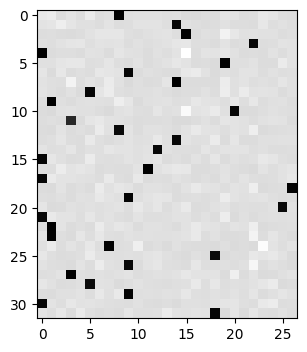

In [106]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='grey')

In [107]:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, k   eepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# can be expressed as

hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [108]:
bngain.shape, hprebn.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [109]:
hprebn.mean(0, keepdim=True).shape

torch.Size([1, 64])

In [110]:
(bngain*bnvar_inv/n).shape, (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)).shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [111]:
(n/(n-1)*bnraw*(dhpreact*bnraw)).shape

torch.Size([32, 64])

In [112]:
(n*dhpreact - dhpreact.sum(0,keepdim=True)).shape, (n/(n-1)*bnraw*(dhpreact*bnraw)).sum(0, keepdim=True).shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [113]:
# calculating the derative of hprebn directly instead of all the intermeidate calculates
# all of the calculations were done on paper ... it looks like there was no work prior to this lol

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0, keepdim=True) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0, keepdim=True))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [120]:
# the entire init and training

block_size = 3
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

# we dont need grads since we have our own
with torch.no_grad():

  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation

    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias

    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later

    # manual backprop!
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)

    # tanh
    dhpreact = (1.0 - h**2) * dh

    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # when using .backward() in pt
      p.data += -lr * grad # new way :)

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #if i >= 100: # delete early breaking when you're ready to train the full net
      #break

12297
      0/ 200000: 3.7616
  10000/ 200000: 2.1820
  20000/ 200000: 2.3890
  30000/ 200000: 2.4274
  40000/ 200000: 2.0157
  50000/ 200000: 2.3641
  60000/ 200000: 2.4091
  70000/ 200000: 2.0794
  80000/ 200000: 2.3827
  90000/ 200000: 2.1640
 100000/ 200000: 1.9752
 110000/ 200000: 2.4077
 120000/ 200000: 2.0239
 130000/ 200000: 2.4285
 140000/ 200000: 2.2795
 150000/ 200000: 2.2057
 160000/ 200000: 1.9761
 170000/ 200000: 1.8277
 180000/ 200000: 2.0136
 190000/ 200000: 1.8477


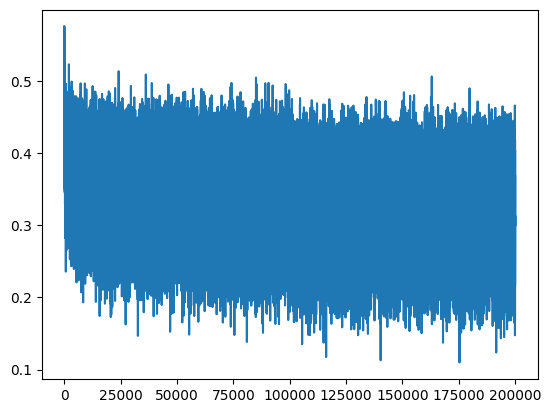

In [121]:
plt.plot(lossi)

In [117]:
for p,g in zip(parameters, grads):
   cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.259629011154175e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [124]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [125]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0711240768432617
val 2.108812093734741


In [150]:
# sample from the model
g = torch.Generator().manual_seed(9742232)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itoc[i] for i in out))

savin.
tradynie.
hassitan.
carlisa.
caliya.
tney.
kaikory.
ery.
emma.
jachar.
adel.
merhlanickenther.
bowdley.
jeste.
lloriya.
advi.
aphiro.
blerice.
cora.
ismari.
